# Planify - Graph Neural Network

### Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
    <ul>
        <li><a href="#Imports">Imports</a></li>
        <li><a href="#func">Functions used</a></li>
    </ul>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#model">GNN Model</a></li>
    <ul>
        <li><a href="#dataLoader">Data Loader</a></li>
        <li><a href="#archi">Architecture</a></li>
        <li><a href="#train">Training</a></li> 
        <li><a href="#eval">Evaluation</a></li>
    </ul>
</ul>

<a id='intro'></a>
## Introduction

> This notebook getting garphs in the Networkx format from the `Creating Graphs` notebook. And its main goal is to make the GNN model.

In [1]:
# Used for vsCode only to show tqdm process
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

<a id='Imports'></a>
### Imports

In [2]:
# Not included packages in kaggle

# Install torch_geometric
!pip install torch_geometric
!pip install /kaggle/input/torch-geometric/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl -q
!pip install /kaggle/input/torch-geometric/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl -q

# # # library for getting distinct colores
!pip install distinctipy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 7.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=29e678ad74cf53465dfc779072c9d7e831db9a80f1fe7187117398e43e105d3c
  Stored in directory: /root/.cache/pip/wheels/83/b2/dc/5a92df31573f946e8f3ca62b861be8a6a55c5228ed27cc989b
Successfully built torch_geometric


In [3]:
# for data wrangling
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import distinctipy
import random
from torch_geometric.utils import from_networkx

# to show advance in for loops
from tqdm import tqdm

# Using pytorch geometric
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset
import torch_geometric.transforms as T


# For the GNN model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool


# for my pc
# url = '/media/mo/DATA/Grad/Planify_Dataset/Graph/Planify_Graphs.pkl'

# for kaggle
url = '/kaggle/input/planify-graphs/Planify_Graphs.pkl'

<a id='func'></a>
### Functions used

In [4]:
geoms_columns = ['inner', 'living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'wall-in',
                    'outer_wall', 'front', 'inner_wall', 'interior',
                   'front_door', 'outer_wall', 'entrance']

N = len(geoms_columns)
colors = (np.array(distinctipy.get_colors(N)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(geoms_columns)}

In [5]:
def draw_graph(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}
    
    scales = [G.nodes[node]['roomSize'] * 10000 for node in G] 
    colormap = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]
    
    nx.draw(G, pos=pos, node_size=scales, node_color=colormap, with_labels=True, font_size=12)
    
    # Drawing the graph inside a good boundary.
    x_coords  = [pos[node][0] for node in pos]
    y_coords  = [pos[node][1] for node in pos]
    threshold = max(scales) / 100
    
    plt.xlim(min(x_coords) - threshold, max(x_coords) + threshold)
    plt.ylim(min(y_coords) - threshold, max(y_coords) + threshold)


def collate_fn(graphs_list):
    batch = Batch.from_data_list([Data.from_(g) for g in graphs_list])
    return batch

<a id='wrangling'></a>
## Data wrangling


Graph with 7 nodes and 9 edges


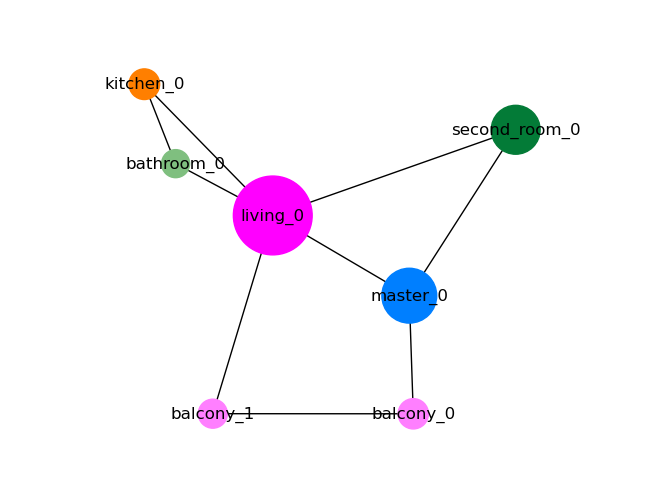

In [6]:
with open(url, 'rb') as f:
    Graphs = pickle.load(f)
    
G = Graphs[1911]
print(G)
draw_graph(G)

In [24]:
features = ['actualCentroid_x', 'actualCentroid_y', 'rec_w', 'rec_h', 'roomSize']

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:
# Converting networkx graphs to pytorchGeo graphs
Graphs_pyTorch = []
for G in tqdm(Graphs):
    G_new = from_networkx(G, group_node_attrs=features, group_edge_attrs=['dist'])
    # Normalizing feature matrix (x)
    G_new = T.NormalizeFeatures()(G_new)
    
    Graphs_pyTorch.append(G_new)

Graphs_pyTorch[0]

100%|██████████| 80788/80788 [01:00<00:00, 1345.25it/s]


Data(edge_index=[2, 12], roomType_name=[5], roomType_embd=[5], x=[5, 5], edge_attr=[12, 1])

> There are many types of `rooms` but we will give them a defualt number = 1.
> So, also we will decrease the embedings to be between 0:6

In [28]:
print(f'Befor: G_1 embedings are: {Graphs_pyTorch[1].roomType_embd}')
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    for j ,value in enumerate(G.roomType_embd):
        if value in [1, 4, 5, 6, 7, 8]:
            G.roomType_embd[j] = 1
        
        # making all labels from 0 to 6 only to help one_hotting
        elif value == 9:
            G.roomType_embd[j] = 4
        elif value == 10:
            G.roomType_embd[j] = 5
        elif value == 11:
            G.roomType_embd[j] = 6
print(f'After: G_1 embedings are: {Graphs_pyTorch[1].roomType_embd}')

Befor: G_1 embedings are: tensor([ 0,  1,  2,  3,  7,  7,  9, 10])


100%|██████████| 80788/80788 [00:16<00:00, 5045.53it/s]

After: G_1 embedings are: tensor([0, 1, 2, 3, 1, 1, 4, 5])


> If we need to creat graphs with padding by the maximum number of nodes.

In [11]:
# # but we need to do some padding to our graphs to be all of the same number of nodes.
# padded_graphs = []
# for G in Graphs_pyTorch:
#     x          = G.x
#     y          = G.roomType_embd
#     edge_index = G.edge_index
#     edge_attr  = G.edge_attr
    
#     nu_nodes = x.shape[0]

#     padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
#     padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
#     train_mask   = torch.ones(nu_nodes)
#     train_mask   = torch.nn.functional.pad(train_mask, pad=(0, 8 - nu_nodes), mode='constant', value=0).to(bool)

#     data = Data(x = padded_x, y = padded_y, edge_index= G.edge_index, edge_attr = G.edge_attr, train_mask=train_mask)

#     padded_graphs.append(data)

# padded_graphs[0]

<a id='model'></a>
## GNN Model

<a id='dataLoader'></a>
### Data Loader

In [29]:
class Planify_Dataset(Dataset):
    def __init__(self, data):
        self.Graphs = data
    
    def __len__(self):
        return len(self.Graphs)

    def __getitem__(self, index):
        G = self.Graphs[index].clone()

        
        # shuffling nodes inside the same graph
        permutation = torch.randperm(G.num_nodes)
        
        G.x = G.x[permutation]
        G.edge_index = permutation[G.edge_index]
        G.roomType_embd = G.roomType_embd[permutation]
        
        # padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
        # padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
                
        return G

In [44]:
# There is a problem here.

batch_size = 32
dataset = Planify_Dataset(Graphs_pyTorch)
loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)

<a id='archi'></a>
### Architecture

In [45]:
class GCN(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, nu_classes):
        super().__init__()
        self.gc1 = GATConv(input_channels, hidden_channels, heads=8)
        self.gc2 = GATConv(hidden_channels * 8, hidden_channels * 8, heads=8)
        self.gc3 = GATConv(hidden_channels * 8 * 8, hidden_channels * 8, heads=8)
        
        self.fc1 = nn.Linear(hidden_channels * 8 * 8, nu_classes * 8)
        self.fc2 = nn.Linear(nu_classes * 8, nu_classes)
        
        self.Classifier = nn.Linear(nu_classes, nu_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.gc1(x, edge_index)
        x = x.relu()
        # x = F.dropout(x, training=self.training)

        x = self.gc2(x, edge_index)
        x = x.relu()
        # x = F.dropout(x, training=self.training)
        
        x = self.gc3(x, edge_index)
        x = x.relu()
        
        x = self.fc1(x)
        x = x.relu()
        
        x = self.fc2(x)
        x = x.relu()
        
        x = self.Classifier(x)
        x = self.Classifier(x)
        
        return x.relu()
    


nu_features    = Graphs_pyTorch[0].x.shape[0]
# number_classes = 12 # there is 12 distict classes in our dataset
number_classes = 7 # if we consider all rooms has the same label = 1


model = GCN(nu_features, hidden_channels=16, nu_classes=number_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# to monitor the loss & accuracy.
errors = []
acc = []
model

GCN(
  (gc1): GATConv(5, 16, heads=8)
  (gc2): GATConv(128, 128, heads=8)
  (gc3): GATConv(1024, 128, heads=8)
  (fc1): Linear(in_features=1024, out_features=56, bias=True)
  (fc2): Linear(in_features=56, out_features=7, bias=True)
  (Classifier): Linear(in_features=7, out_features=7, bias=True)
)

In [51]:
# Hyperparameters
learning_rate = 0.001
nu_epochs = 1000

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.972)

# def scheduler(epoch, lr)
#     if epoch < 20:
#         return lr
#     else:
#         return lr * 0.99

<a id='train'></a>
### Training


In [52]:
# Saving model function
import os

checkpoint_dir = '/kaggle/working/checkpoints'
# checkpoint_dir = '/media/mo/DATA/Grad/Planify_Dataset/Graph/checkpoints'

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
def save_checkpoint(model, optimizer, epoch):
    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
    # Saving model each 15 epochs
    if epoch % 15 == 0:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch
        }, checkpoint_path)

In [ ]:
for epoch in range(nu_epochs):
    running_loss = 0.0
    train_acc    = 0.0
    for i, data in tqdm(enumerate(loader), desc='Planifying', total=len(loader)):
        optimizer.zero_grad()

        
        # Forward pass 
        logits    = model(data.to(device)).to(device)
        
        # print(logits.shape)
        # one_hot_y = F.one_hot(data.roomType_embd, num_classes=number_classes).float()
        # computing loss through crossEntropy loss function
        loss = criterion(logits, data.roomType_embd)

        # Backward pass
        loss.backward()

        # Updating parameters
        optimizer.step()
        # current_lr = optimizer.param_groups[0]['lr']
        # optimizer = torch.optim.Adam(model.parameters(), lr=scheduler(epoch, current_lr))

        # Monitoring
        running_loss += loss.item()
        train_acc += (torch.argmax(logits, 1).flatten() == data.roomType_embd).type(torch.float).mean().item()
        lr = optimizer.param_groups[0]['lr']
        
        
    print(data.roomType_embd[:10])
    print(torch.argmax(logits, 1)[:10])
        
    errors.append(loss.item())
    acc.append(train_acc/len(loader) * 100)

    # Updating scheduler each 15 epochs.
    scheduler.step()
    
    # Saving the model.
    # save_checkpoint(model, optimizer, epoch)
    
    # Monitoring and printing.
    batch_size = len(loader)
    print(f'Epoch: {epoch + 1}/{nu_epochs} | lr: {lr} | avg_loss: {running_loss/batch_size:.5f} | training_acc: {train_acc/batch_size * 100:.5f}%')


Planifying: 100%|██████████| 2525/2525 [00:44<00:00, 56.29it/s]


tensor([0, 3, 3, 1, 2, 1, 1, 4, 1, 1], device='cuda:0')
tensor([0, 3, 3, 1, 1, 1, 3, 4, 3, 1], device='cuda:0')
Epoch: 1/1000 | lr: 0.001 | avg_loss: 0.97302 | training_acc: 62.03293%


Planifying: 100%|██████████| 2525/2525 [00:44<00:00, 56.78it/s]


tensor([1, 4, 1, 3, 4, 0, 2, 0, 1, 4], device='cuda:0')
tensor([1, 4, 1, 3, 4, 0, 4, 0, 3, 4], device='cuda:0')
Epoch: 2/1000 | lr: 0.001 | avg_loss: 0.95770 | training_acc: 62.80214%


Planifying: 100%|██████████| 2525/2525 [00:43<00:00, 57.39it/s]


tensor([2, 1, 4, 1, 0, 3, 1, 1, 2, 1], device='cuda:0')
tensor([1, 1, 4, 1, 0, 4, 1, 1, 0, 1], device='cuda:0')
Epoch: 3/1000 | lr: 0.000972 | avg_loss: 0.94843 | training_acc: 63.12110%


Planifying:  34%|███▎      | 850/2525 [00:15<00:28, 59.20it/s]

In [ ]:
err = [num * 35 for num in errors]
err

In [ ]:
# plt.plot(errors);
plt.plot(acc, label='accuracy');
plt.plot(err, label='error');
plt.legend();